In [5]:
# ==================== CONFIG (run this first) ====================
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

# ---- 可调参数 ----
HIDDEN_FC   = 128
BASE_EPOCHS = 2     # 提高到 5-10 会有更高 baseline 精度
FT_EPOCHS   = 2
BATCH_SIZE  = 128
BASE_LR     = 0.01
FT_LR       = 0.001
BASE_OPTIM  = 'SGD'   # 'SGD' | 'Adam'
FT_OPTIM    = 'Adam'  # 'SGD' | 'Adam'

# 剪枝配置（可按需增删/改比例）
PRUNE_CONFIGS = [
    {"name": "unstructured_l1", "amount": 0.7},
    {"name": "vector_out",      "amount": 0.3},
    {"name": "vector_in",       "amount": 0.25},
    {"name": "channel",         "amount": 0.3},
    {"name": "kernel",          "amount": 0.3},
    {"name": "group",           "group_size": 4, "num_groups_to_prune": 1}
]

# 目标阈值（自动判定是否“达标”）
MAX_ACC_DROP = 0.01     # 精度最多下降 1%
MIN_MACS_DROP = 0.3     # 计算量至少下降 30%（仅对结构化有效）

# 绘图开关（如遇崩溃可关）
USE_PLOTS = True

import torch
torch.set_num_threads(1)
DEVICE = torch.device('cpu')
print('Using device:', DEVICE)
torch.manual_seed(2025)

Using device: cpu


In [6]:
# ==================== MODEL / DATA / UTILS ====================
import copy
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision, torchvision.transforms as T

# ---- 数据 ----
transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False)

# ---- 模型 ----
class SmallConvNet(nn.Module):
    def __init__(self, fc_hidden=HIDDEN_FC):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2)
        self.fc    = nn.Linear(32*7*7, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

# ---- 优化器 / 训练 / 测试 ----
def make_opt(name, params, lr):
    return optim.SGD(params, lr=lr, momentum=0.9) if name=='SGD' else optim.Adam(params, lr=lr)

@torch.inference_mode()
def test_acc(model, loader):
    model.eval(); tot=0; corr=0
    for X,y in loader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        pred = model(X).argmax(1)
        corr += (pred==y).sum().item(); tot += y.size(0)
    return corr/tot

def train_epochs(model, loader, opt, epochs):
    model.train()
    for _ in range(epochs):
        for X,y in loader:
            X,y = X.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            F.cross_entropy(model(X), y).backward()
            opt.step()

# ---- 统计 ----
@torch.no_grad()
def count_params_zeros(model):
    tot=zeros=0
    for _,p in model.named_parameters():
        tot+=p.numel(); zeros+=(p==0).sum().item()
    return tot, zeros, zeros/tot

# ---- MACs 估算（Conv/Linear）----
def conv2d_macs(Hin, Win, Cin, Cout, Kh, Kw, stride=1, pad=1):
    Hout = (Hin + 2*pad - Kh)//stride + 1
    Wout = (Win + 2*pad - Kw)//stride + 1
    macs = Hout*Wout*Cout*(Cin*Kh*Kw)
    return macs, Hout, Wout

def maxpool2d_size(Hin, Win, k=2, stride=2):
    Hout = (Hin - k)//stride + 1
    Wout = (Win - k)//stride + 1
    return Hout, Wout

def model_macs(model):
    H,W,Cin = 28,28,1
    # conv1
    Cout1 = model.conv1.out_channels; Kh1,Kw1 = model.conv1.kernel_size
    mac1, H1, W1 = conv2d_macs(H,W,Cin,Cout1,Kh1,Kw1,stride=1,pad=model.conv1.padding[0])
    H1p,W1p = maxpool2d_size(H1,W1)
    # conv2
    Cin2 = Cout1; Cout2 = model.conv2.out_channels; Kh2,Kw2 = model.conv2.kernel_size
    mac2, H2, W2 = conv2d_macs(H1p,W1p,Cin2,Cout2,Kh2,Kw2,stride=1,pad=model.conv2.padding[0])
    H2p,W2p = maxpool2d_size(H2,W2)
    # fc
    mac_fc = (Cout2*H2p*W2p) * model.fc.out_features
    return mac1 + mac2 + mac_fc

# ---- 剪枝函数们 (unstructured, vector, channel, kernel, group) ----
def prune_unstructured_l1(model, amount):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(m, 'weight', amount=amount); prune.remove(m, 'weight')

def prune_vector_out(model, amount):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            prune.ln_structured(m, 'weight', amount=amount, n=2, dim=0); prune.remove(m, 'weight')

def prune_vector_in(model, amount):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            prune.ln_structured(m, 'weight', amount=amount, n=2, dim=1); prune.remove(m, 'weight')

def prune_channel(model, amount):
    prune_vector_out(model, amount)

@torch.no_grad()
def prune_kernel(model, fraction):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            W = m.weight.detach().clone()
            O,I,Kh,Kw = W.shape
            norms = (W.pow(2).sum(dim=(2,3))).sqrt().flatten()
            k_prune = max(1, int(norms.numel()*fraction))
            _, idx = torch.sort(norms)
            idx = idx[:k_prune]
            mask = torch.ones_like(W)
            for f in idx.tolist():
                o = f // I; i = f % I
                mask[o,i,:,:] = 0
            prune.CustomFromMask.apply(m, 'weight', mask=mask); prune.remove(m, 'weight')

# ---- 辅助：检测整通道是否全 0（Conv2d 的 weight: [Cout, Cin, Kh, Kw]）----
@torch.no_grad()
def conv_nonzero_channel_masks(weight: torch.Tensor):
    # 输出通道维（dim=0）是否“仍有非零”
    out_mask = (weight.view(weight.size(0), -1) != 0).any(dim=1)   # [Cout]
    # 输入通道维（dim=1）是否“仍有非零”
    in_mask  = (weight.permute(1,0,2,3).contiguous().view(weight.size(1), -1) != 0).any(dim=1)  # [Cin]
    return out_mask, in_mask

def model_macs(model):
    """
    基于 “整通道是否完全为0” 来估算有效通道数量，再计算 MACs（≈ FLOPs/2）。
    - 结构化（向量/通道/组级）剪枝：会让整通道为0 => MACs 下降
    - 非结构化 / 核剪枝：通常不会让整通道全0 => MACs 基本不变
    注意：这里只是估算计算量，模型实际 forward 的张量形状并未真的改变。
    """
    # 输入 1x28x28（MNIST）
    H, W = 28, 28

    # conv1
    w1 = model.conv1.weight.detach()
    out1_mask, in1_mask = conv_nonzero_channel_masks(w1)
    Cin1_eff  = int(in1_mask.sum().item())   # 理论上=1（MNIST单通道），但保守写法
    Cout1_eff = int(out1_mask.sum().item())
    Cin1_eff  = max(Cin1_eff,  1)
    Cout1_eff = max(Cout1_eff, 1)
    mac1, H1, W1 = conv2d_macs(H, W, Cin1_eff, Cout1_eff, Kh=3, Kw=3, stride=1, pad=1)
    H1p, W1p = maxpool2d_size(H1, W1)

    # conv2
    w2 = model.conv2.weight.detach()
    out2_mask, in2_mask = conv_nonzero_channel_masks(w2)
    Cin2_eff  = int(in2_mask.sum().item())
    Cout2_eff = int(out2_mask.sum().item())
    # Cin2_eff 也受 conv1 的有效输出通道影响，取二者较小值更保守
    Cin2_eff  = max(min(Cin2_eff, Cout1_eff), 1)
    Cout2_eff = max(Cout2_eff, 1)
    mac2, H2, W2 = conv2d_macs(H1p, W1p, Cin2_eff, Cout2_eff, Kh=3, Kw=3, stride=1, pad=1)
    H2p, W2p = maxpool2d_size(H2, W2)

    # fc（输入特征数随 conv2 的有效输出通道变化）
    in_fc_eff  = Cout2_eff * H2p * W2p
    out_fc     = model.fc.out_features
    mac_fc     = in_fc_eff * out_fc

    return mac1 + mac2 + mac_fc

def apply_prune(model, cfg):
    name = cfg['name']
    if name=='unstructured_l1':
        prune_unstructured_l1(model, cfg.get('amount',0.7))
    elif name=='vector_out':
        prune_vector_out(model, cfg.get('amount',0.3))
    elif name=='vector_in':
        prune_vector_in(model, cfg.get('amount',0.25))
    elif name=='channel':
        prune_channel(model, cfg.get('amount',0.3))
    elif name=='kernel':
        prune_kernel(model, cfg.get('amount',0.3))
    elif name=='group':
        prune_group(model, cfg.get('group_size',4), cfg.get('num_groups_to_prune',1))
    else:
        raise ValueError(f'Unknown prune name: {name}')

In [7]:
# ==================== RUN & COLLECT ====================
rows = []

# 基线
base = SmallConvNet().to(DEVICE)
opt_base = make_opt(BASE_OPTIM, base.parameters(), BASE_LR)
train_epochs(base, trainloader, opt_base, BASE_EPOCHS)
acc_base = test_acc(base, testloader)
p_b, z_b, s_b = count_params_zeros(base)
macs_b = model_macs(base)
print(f"[Baseline] acc={acc_base:.4f}, sparsity={s_b:.3f}, params={p_b}, MACs={macs_b}")
rows.append({
    'method':'Baseline','amount':'-',
    'acc_pruned':round(acc_base,4),'acc_ft':round(acc_base,4),
    'params':p_b,'zeros':z_b,'sparsity':round(s_b,4),'MACs':macs_b,
    'MACs_drop(%)':0.0
})

# 多剪枝方案
for cfg in PRUNE_CONFIGS:
    m = SmallConvNet().to(DEVICE)
    m.load_state_dict(copy.deepcopy(base.state_dict()))
    macs_before = model_macs(m)
    # 剪枝
    apply_prune(m, cfg)
    # 剪后统计
    acc_p = test_acc(m, testloader)
    p, z, s = count_params_zeros(m)
    macs_after = model_macs(m)  # 仅结构化会真正下降
    # 微调
    opt_ft = make_opt(FT_OPTIM, m.parameters(), FT_LR)
    train_epochs(m, trainloader, opt_ft, FT_EPOCHS)
    acc_ft = test_acc(m, testloader)
    rows.append({
        'method':cfg['name'],
        'amount':{k:v for k,v in cfg.items() if k!='name'},
        'acc_pruned':round(acc_p,4), 'acc_ft':round(acc_ft,4),
        'params':p, 'zeros':z, 'sparsity':round(s,4),
        'MACs':macs_after,
        'MACs_drop(%)': round(100*(1 - macs_after/max(macs_before,1)),2)
    })

import pandas as pd
df = pd.DataFrame(rows)
print('\n=== Summary ===')
print(df.to_string(index=False))

# 保存一份 csv（可选）
try:
    df.to_csv('mnist_pruning_summary.csv', index=False)
    print('\nSaved: mnist_pruning_summary.csv')
except Exception as e:
    print('Save csv skipped:', repr(e))

[Baseline] acc=0.9801, sparsity=0.000, params=20490, MACs=1031744

=== Summary ===
         method                                      amount  acc_pruned  acc_ft  params  zeros  sparsity    MACs  MACs_drop(%)
       Baseline                                           -      0.9801  0.9801   20490      0    0.0000 1031744          0.00
unstructured_l1                             {'amount': 0.7}      0.9579  0.9864   20490  14303    0.6980  904736         12.31
     vector_out                             {'amount': 0.3}      0.9779  0.9868   20490   1485    0.0725  515284         50.06
      vector_in                            {'amount': 0.25}      0.9782  0.9859   20490   1152    0.0562  805952         21.88
        channel                             {'amount': 0.3}      0.9779  0.9833   20490   1485    0.0725  515284         50.06
         kernel                             {'amount': 0.3}      0.9756  0.9871   20490   1413    0.0690  777728         24.62
          group {'group_size

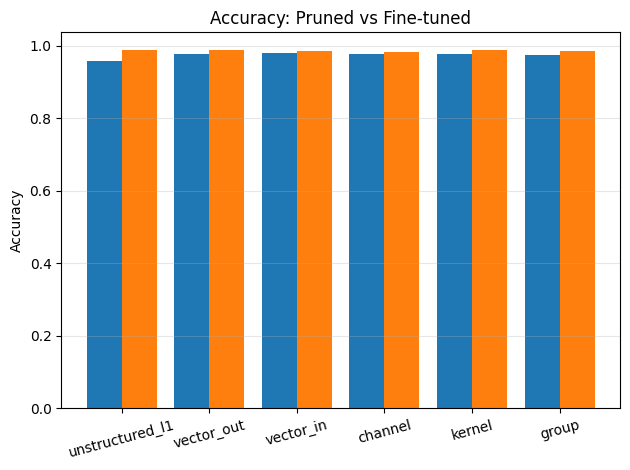

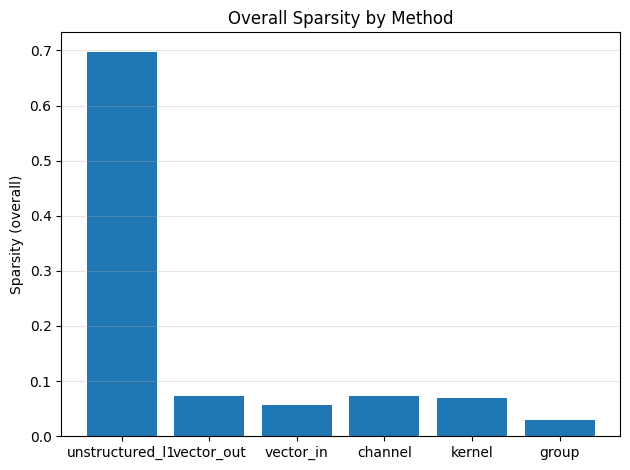

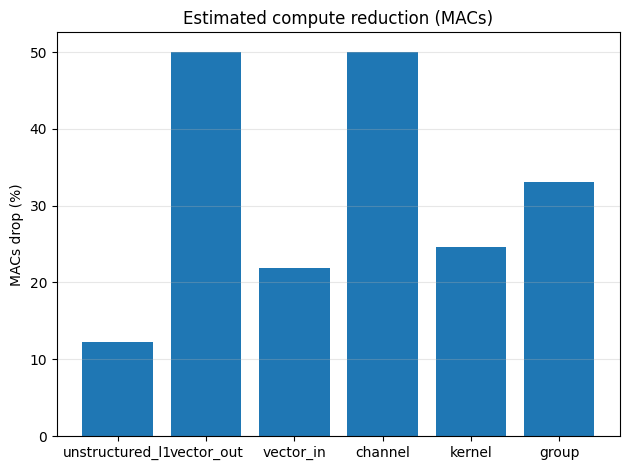


=== Decision (vs thresholds) ===
         method  acc_ft  acc_drop  MACs_drop(%)  meets_accuracy?  meets_compute?(structured)
unstructured_l1  0.9864   -0.0063         12.31             True                        True
     vector_out  0.9868   -0.0067         50.06             True                        True
      vector_in  0.9859   -0.0058         21.88             True                       False
        channel  0.9833   -0.0032         50.06             True                        True
         kernel  0.9871   -0.0070         24.62             True                        True
          group  0.9861   -0.0060         33.02             True                        True


In [8]:
# ==================== PLOTS & DECISION ====================
def safe_plot(fn, *args, **kwargs):
    if not USE_PLOTS:
        print('Plot disabled.')
        return
    try:
        fn(*args, **kwargs)
    except Exception as e:
        print('Plot skipped:', repr(e))

import matplotlib.pyplot as plt

def plot_acc():
    plt.figure()
    sub = df[df['method']!='Baseline']
    x = range(len(sub))
    plt.bar([i-0.2 for i in x], sub['acc_pruned'], width=0.4, label='Pruned')
    plt.bar([i+0.2 for i in x], sub['acc_ft'],    width=0.4, label='Fine-tuned')
    plt.xticks(x, sub['method'], rotation=15)
    plt.ylabel('Accuracy')
    plt.title('Accuracy: Pruned vs Fine-tuned')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout(); plt.show()

def plot_sparsity():
    plt.figure()
    sub = df[df['method']!='Baseline']
    plt.bar(sub['method'], sub['sparsity'])
    plt.ylabel('Sparsity (overall)')
    plt.title('Overall Sparsity by Method')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout(); plt.show()

def plot_macs():
    plt.figure()
    sub = df[df['method']!='Baseline']
    plt.bar(sub['method'], sub['MACs_drop(%)'])
    plt.ylabel('MACs drop (%)')
    plt.title('Estimated compute reduction (MACs)')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout(); plt.show()

safe_plot(plot_acc)
safe_plot(plot_sparsity)
safe_plot(plot_macs)

# ---- 自动达标判断 ----
base_acc = float(df.loc[df['method']=='Baseline', 'acc_ft'].iloc[0])

decisions = []
for i, row in df.iterrows():
    if row['method']=='Baseline':
        continue
    acc_drop = base_acc - float(row['acc_ft'])
    macs_drop = float(row['MACs_drop(%)'])/100.0
    meet_acc = (acc_drop <= MAX_ACC_DROP + 1e-9)
    # 对非结构化/核/组级：MACs 不一定降，这里只作提示，不强制要求
    is_structured = row['method'] in ('vector_out','vector_in','channel','group')
    meet_macs = (not is_structured) or (macs_drop >= MIN_MACS_DROP - 1e-9)
    decisions.append({
        'method': row['method'],
        'acc_ft': row['acc_ft'],
        'acc_drop': round(acc_drop,4),
        'MACs_drop(%)': row['MACs_drop(%)'],
        'meets_accuracy?': meet_acc,
        'meets_compute?(structured)': meet_macs
    })

dec_df = pd.DataFrame(decisions)
print('\n=== Decision (vs thresholds) ===')
print(dec_df.to_string(index=False))

Using device: cpu
[Baseline] acc=0.9801, sparsity=0.000, params=20490, MACs=1031744

=== Summary ===
         method                                      amount  acc_pruned  acc_ft  params  zeros  sparsity    MACs  MACs_drop(%)
       Baseline                                           -      0.9801  0.9801   20490      0    0.0000 1031744          0.00
unstructured_l1                             {'amount': 0.7}      0.9579  0.9864   20490  14303    0.6980  901266         12.65
     vector_out                             {'amount': 0.3}      0.9779  0.9868   20490   1485    0.0725  515284         50.06
      vector_in                            {'amount': 0.25}      0.9782  0.9859   20490   1152    0.0562  805952         21.88
        channel                             {'amount': 0.3}      0.9779  0.9833   20490   1485    0.0725  515284         50.06
         kernel                             {'amount': 0.3}      0.9756  0.9871   20490   1413    0.0690  777728         24.62
          

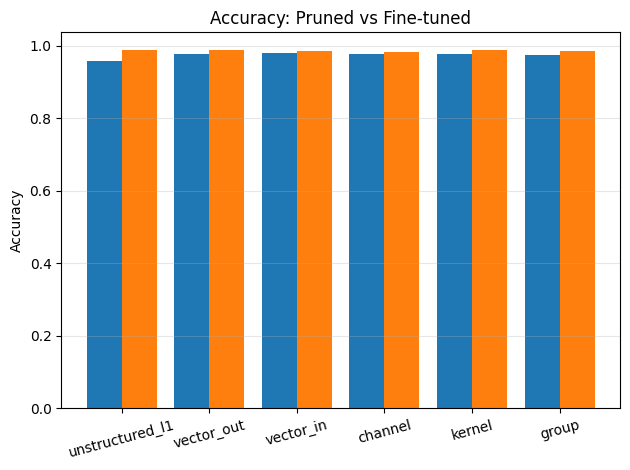

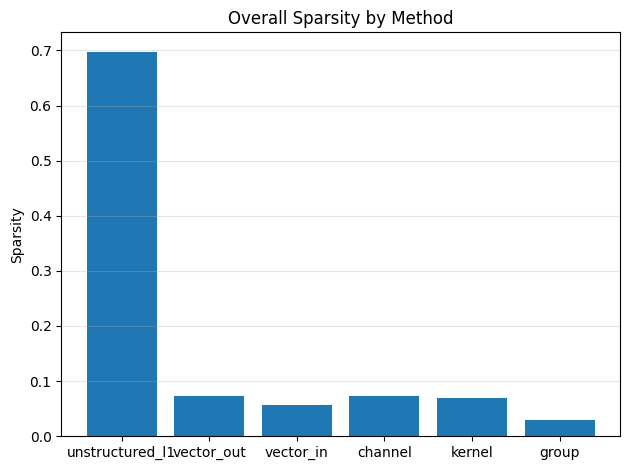

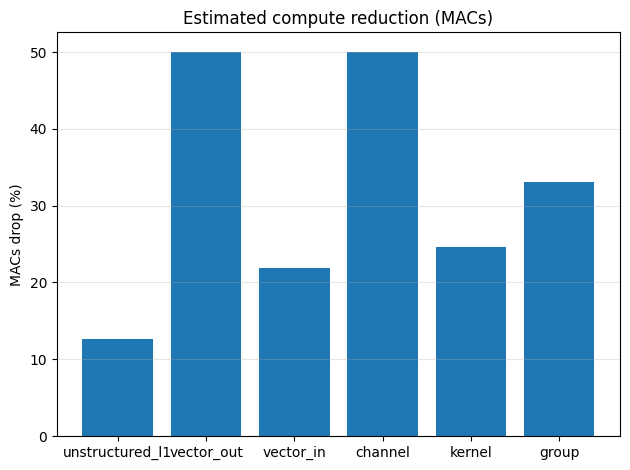


=== Decision (vs thresholds) ===
         method  acc_ft  acc_drop  MACs_drop(%)  meets_accuracy?  meets_compute?(structured)
unstructured_l1  0.9864   -0.0063         12.65             True                        True
     vector_out  0.9868   -0.0067         50.06             True                        True
      vector_in  0.9859   -0.0058         21.88             True                       False
        channel  0.9833   -0.0032         50.06             True                        True
         kernel  0.9871   -0.0070         24.62             True                        True
          group  0.9861   -0.0060         33.02             True                        True


In [9]:
# ================================================
# MNIST 剪枝 Dashboard（含结构化计算量真实下降统计）
# ================================================
# —— 可调参数 —— #
HIDDEN_FC   = 128
BASE_EPOCHS = 2         # 可调到 5-10 获得更高 baseline
FT_EPOCHS   = 2
BATCH_SIZE  = 128
BASE_LR     = 0.01
FT_LR       = 0.001
BASE_OPTIM  = "SGD"     # "SGD" | "Adam"
FT_OPTIM    = "Adam"    # "SGD" | "Adam"
USE_PLOTS   = True      # 如遇绘图问题设为 False

# 剪枝方案列表（按需增删/改比例）
PRUNE_CONFIGS = [
    {"name": "unstructured_l1", "amount": 0.7},                    # 非结构化 L1（逐元素）
    {"name": "vector_out",      "amount": 0.3},                    # 结构化：按输出通道
    {"name": "vector_in",       "amount": 0.25},                   # 结构化：按输入通道
    {"name": "channel",         "amount": 0.3},                    # 结构化：通道（同 vector_out）
    {"name": "kernel",          "amount": 0.3},                    # 核剪枝：按(out,in)核
    {"name": "group",           "group_size": 4, "num_groups_to_prune": 1},  # 组级：每4通道一组剪1组
]

# 阈值（用于自动“是否达标”判断）
MAX_ACC_DROP = 0.01     # 精度最多下降 1%
MIN_MACS_DROP = 0.30    # 结构化方案计算量至少下降 30%

# —— 稳定性设置 —— #
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import torch, copy
torch.set_num_threads(1)
DEVICE = torch.device("cpu")
torch.manual_seed(2025)
print("Using device:", DEVICE)

# —— 依赖 —— #
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision, torchvision.transforms as T
import pandas as pd

# -----------------------
# 数据
# -----------------------
transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root="./data", train=True,  download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False)

# -----------------------
# 模型：Conv→Conv→FC
# 28x28 -> conv(16) -> pool -> conv(32) -> pool -> 7x7 -> FC(10)
# -----------------------
class SmallConvNet(nn.Module):
    def __init__(self, fc_hidden=HIDDEN_FC):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2)
        self.fc    = nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B,16,14,14]
        x = self.pool(F.relu(self.conv2(x)))  # [B,32, 7, 7]
        x = x.view(x.size(0), -1)
        return self.fc(x)

# -----------------------
# 优化器 / 训练 / 测试
# -----------------------
def make_opt(name, params, lr):
    return optim.SGD(params, lr=lr, momentum=0.9) if name=="SGD" else optim.Adam(params, lr=lr)

@torch.inference_mode()
def test_acc(model, loader):
    model.eval(); tot=0; corr=0
    for X,y in loader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        pred = model(X).argmax(1)
        corr += (pred==y).sum().item()
        tot  += y.size(0)
    return corr/tot

def train_epochs(model, loader, opt, epochs):
    model.train()
    for _ in range(epochs):
        for X,y in loader:
            X,y = X.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            F.cross_entropy(model(X), y).backward()
            opt.step()

# -----------------------
# 统计：参数/稀疏率
# -----------------------
@torch.no_grad()
def count_params_zeros(model):
    tot=0; zeros=0
    for _,p in model.named_parameters():
        tot   += p.numel()
        zeros += (p==0).sum().item()
    spars = zeros/tot
    return tot, zeros, spars

# -----------------------
# MACs 估算（Conv/Linear）
# ✅ 按“整通道/整行是否全 0”重算有效通道/神经元，使结构化剪枝看到真实计算量下降
# -----------------------
def conv2d_macs(Hin, Win, Cin, Cout, Kh, Kw, stride=1, pad=1):
    Hout = (Hin + 2*pad - Kh)//stride + 1
    Wout = (Win + 2*pad - Kw)//stride + 1
    macs = Hout*Wout*Cout*(Cin*Kh*Kw)  # MACs
    return macs, Hout, Wout

def maxpool2d_size(Hin, Win, k=2, stride=2):
    Hout = (Hin - k)//stride + 1
    Wout = (Win - k)//stride + 1
    return Hout, Wout

@torch.no_grad()
def conv_nonzero_channel_masks(weight: torch.Tensor):
    # weight: [Cout, Cin, Kh, Kw]
    # 输出通道维（dim=0）是否仍有非零
    out_mask = (weight.view(weight.size(0), -1) != 0).any(dim=1)   # [Cout]
    # 输入通道维（dim=1）是否仍有非零
    in_mask  = (weight.permute(1,0,2,3).contiguous().view(weight.size(1), -1) != 0).any(dim=1)  # [Cin]
    return out_mask, in_mask

@torch.no_grad()
def linear_nonzero_rowcol_masks(weight: torch.Tensor):
    # weight: [out_features, in_features]
    row_mask = (weight != 0).any(dim=1)  # 哪些输出神经元（行）仍有非零
    col_mask = (weight != 0).any(dim=0)  # 哪些输入特征（列）仍有非零
    return row_mask, col_mask

def model_macs(model: SmallConvNet):
    """
    基于“整通道/整行是否全 0”估算 MACs：
      - Conv 层：统计有效 Cin/Cout
      - FC 层：统计有效输入列/输出行（若整行全 0 视为被删掉的神经元）
    注意：这里只估算计算量，模型 forward 形状并未真的改变。
    """
    # 输入 1x28x28
    H, W = 28, 28

    # conv1
    w1 = model.conv1.weight.detach()
    out1_mask, in1_mask = conv_nonzero_channel_masks(w1)
    Cin1_eff  = max(int(in1_mask.sum().item()), 1)   # MNIST Cin=1，一般=1
    Cout1_eff = max(int(out1_mask.sum().item()), 1)
    mac1, H1, W1 = conv2d_macs(H, W, Cin1_eff, Cout1_eff, Kh=3, Kw=3, stride=1, pad=1)
    H1p, W1p = maxpool2d_size(H1, W1)

    # conv2
    w2 = model.conv2.weight.detach()
    out2_mask, in2_mask = conv_nonzero_channel_masks(w2)
    Cin2_eff_raw  = int(in2_mask.sum().item())
    Cout2_eff     = int(out2_mask.sum().item())
    # Cin2 同时受 conv1 输出有效通道影响（下游必须≤上游）
    Cin2_eff      = max(min(Cin2_eff_raw, Cout1_eff), 1)
    Cout2_eff     = max(Cout2_eff, 1)
    mac2, H2, W2 = conv2d_macs(H1p, W1p, Cin2_eff, Cout2_eff, Kh=3, Kw=3, stride=1, pad=1)
    H2p, W2p = maxpool2d_size(H2, W2)

    # fc（输入来自 conv2 的有效输出通道）
    in_fc_eff = Cout2_eff * H2p * W2p
    # 考虑 FC 层权重整行/整列为 0 的情况
    wfc = model.fc.weight.detach()  # [out, in]
    row_mask, col_mask = linear_nonzero_rowcol_masks(wfc)
    out_fc_eff = max(int(row_mask.sum().item()), 1)
    in_fc_eff  = max(min(in_fc_eff, int(col_mask.sum().item())), 1)  # 列也可能被打空
    mac_fc = in_fc_eff * out_fc_eff

    total_macs = mac1 + mac2 + mac_fc
    return int(total_macs)

# -----------------------
# 剪枝实现
# -----------------------
def prune_unstructured_l1(model, amount):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(m, "weight", amount=amount)
            prune.remove(m, "weight")

def prune_vector_out(model, amount):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            prune.ln_structured(m, "weight", amount=amount, n=2, dim=0)
            prune.remove(m, "weight")

def prune_vector_in(model, amount):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            prune.ln_structured(m, "weight", amount=amount, n=2, dim=1)
            prune.remove(m, "weight")

def prune_channel(model, amount):
    prune_vector_out(model, amount)

@torch.no_grad()
def prune_kernel(model, fraction):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            W = m.weight.detach().clone()
            O,I,Kh,Kw = W.shape
            norms = (W.pow(2).sum(dim=(2,3))).sqrt().flatten()   # 每个(out,in)核的L2
            k_prune = max(1, int(norms.numel()*fraction))
            _, idx = torch.sort(norms)                           # 最小的先剪
            idx = idx[:k_prune]
            mask = torch.ones_like(W)
            for f in idx.tolist():
                o = f // I; i = f % I
                mask[o,i,:,:] = 0
            prune.CustomFromMask.apply(m, "weight", mask=mask)
            prune.remove(m, "weight")

@torch.no_grad()
def prune_group(model, group_size=4, num_groups_to_prune=1):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            W = m.weight.detach().clone()
            O,I,Kh,Kw = W.shape
            assert O % group_size == 0, f"out_channels {O} must be divisible by group_size {group_size}"
            G = O // group_size
            norms = []
            for g in range(G):
                s = g*group_size; e = s+group_size
                norms.append(W[s:e].pow(2).sum().sqrt())
            norms = torch.tensor(norms)
            _, order = torch.sort(norms)
            sel = order[:min(num_groups_to_prune, G)]
            mask = torch.ones_like(W)
            for g in sel.tolist():
                s = g*group_size; e = s+group_size
                mask[s:e,:,:,:] = 0
            prune.CustomFromMask.apply(m, "weight", mask=mask)
            prune.remove(m, "weight")

def apply_prune(model, cfg):
    name = cfg["name"]
    if name == "unstructured_l1":
        prune_unstructured_l1(model, cfg.get("amount", 0.7))
    elif name == "vector_out":
        prune_vector_out(model, cfg.get("amount", 0.3))
    elif name == "vector_in":
        prune_vector_in(model, cfg.get("amount", 0.25))
    elif name == "channel":
        prune_channel(model, cfg.get("amount", 0.3))
    elif name == "kernel":
        prune_kernel(model, cfg.get("amount", 0.3))
    elif name == "group":
        prune_group(model, cfg.get("group_size", 4), cfg.get("num_groups_to_prune", 1))
    else:
        raise ValueError(f"Unknown prune name: {name}")

# -----------------------
# 运行实验：基线 -> 各剪枝 -> 微调
# -----------------------
rows = []

# 基线
base = SmallConvNet().to(DEVICE)
opt_base = make_opt(BASE_OPTIM, base.parameters(), BASE_LR)
train_epochs(base, trainloader, opt_base, BASE_EPOCHS)
acc_base = test_acc(base, testloader)
p_b, z_b, s_b = count_params_zeros(base)
macs_b = model_macs(base)
print(f"[Baseline] acc={acc_base:.4f}, sparsity={s_b:.3f}, params={p_b}, MACs={macs_b}")

rows.append({
    "method": "Baseline", "amount": "-",
    "acc_pruned": round(acc_base,4), "acc_ft": round(acc_base,4),
    "params": p_b, "zeros": z_b, "sparsity": round(s_b,4),
    "MACs": macs_b, "MACs_drop(%)": 0.0
})

# 各剪枝方案
for cfg in PRUNE_CONFIGS:
    m = SmallConvNet().to(DEVICE)
    m.load_state_dict(copy.deepcopy(base.state_dict()))

    macs_before = model_macs(m)

    apply_prune(m, cfg)

    acc_p = test_acc(m, testloader)
    p, z, s = count_params_zeros(m)
    macs_after = model_macs(m)  # ✅ 结构化剪枝将看到明显下降

    opt_ft = make_opt(FT_OPTIM, m.parameters(), FT_LR)
    train_epochs(m, trainloader, opt_ft, FT_EPOCHS)
    acc_ft = test_acc(m, testloader)

    rows.append({
        "method": cfg["name"],
        "amount": {k:v for k,v in cfg.items() if k!="name"},
        "acc_pruned": round(acc_p,4), "acc_ft": round(acc_ft,4),
        "params": p, "zeros": z, "sparsity": round(s,4),
        "MACs": macs_after,
        "MACs_drop(%)": round(100*(1 - macs_after/max(macs_before,1)), 2)
    })

df = pd.DataFrame(rows)
print("\n=== Summary ===")
print(df.to_string(index=False))

# 保存结果
try:
    df.to_csv("mnist_pruning_summary.csv", index=False)
    print("\nSaved: mnist_pruning_summary.csv")
except Exception as e:
    print("Save csv skipped:", repr(e))

# -----------------------
# 可选：绘图
# -----------------------
if USE_PLOTS:
    import matplotlib.pyplot as plt
    try:
        sub = df[df["method"]!="Baseline"]
        # 精度柱状：剪后 vs 微调后
        plt.figure()
        x = range(len(sub))
        plt.bar([i-0.2 for i in x], sub["acc_pruned"], width=0.4, label="Pruned")
        plt.bar([i+0.2 for i in x], sub["acc_ft"], width=0.4, label="Fine-tuned")
        plt.xticks(x, sub["method"], rotation=15)
        plt.ylabel("Accuracy"); plt.title("Accuracy: Pruned vs Fine-tuned")
        plt.grid(True, axis="y", alpha=0.3)
        plt.tight_layout(); plt.show()

        # 稀疏率
        plt.figure()
        plt.bar(sub["method"], sub["sparsity"])
        plt.ylabel("Sparsity"); plt.title("Overall Sparsity by Method")
        plt.grid(True, axis="y", alpha=0.3)
        plt.tight_layout(); plt.show()

        # MACs 降幅
        plt.figure()
        plt.bar(sub["method"], sub["MACs_drop(%)"])
        plt.ylabel("MACs drop (%)"); plt.title("Estimated compute reduction (MACs)")
        plt.grid(True, axis="y", alpha=0.3)
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Plot skipped:", repr(e))

# -----------------------
# 自动判定是否“达标”
# -----------------------
base_acc = float(df.loc[df["method"]=="Baseline", "acc_ft"].iloc[0])
decisions = []
for _, row in df.iterrows():
    if row["method"] == "Baseline":
        continue
    acc_drop = base_acc - float(row["acc_ft"])
    macs_drop = float(row["MACs_drop(%)"]) / 100.0
    is_structured = row["method"] in ("vector_out","vector_in","channel","group")
    meet_acc  = (acc_drop <= MAX_ACC_DROP + 1e-9)
    meet_macs = (not is_structured) or (macs_drop >= MIN_MACS_DROP - 1e-9)
    decisions.append({
        "method": row["method"],
        "acc_ft": row["acc_ft"],
        "acc_drop": round(acc_drop,4),
        "MACs_drop(%)": row["MACs_drop(%)"],
        "meets_accuracy?": meet_acc,
        "meets_compute?(structured)": meet_macs
    })

dec_df = pd.DataFrame(decisions)
print("\n=== Decision (vs thresholds) ===")
print(dec_df.to_string(index=False))


In [10]:
# ================================================
# AutoML 剪枝原型：强化学习 (RL) + 元学习风格 (Surrogate)
# ================================================
# 可调参数（统一放在顶部）
MODE = 'rl'          # 'rl' 或 'meta'
EPISODES = 8         # 搜索回合数（建议先小，跑通后可加，比如 20-50）
BASELINE_EPOCHS = 2  # baseline 训练轮次
FINETUNE_EPOCHS = 1  # 每次候选剪枝后的微调轮次（小点以提高搜索速度）
BATCH_SIZE = 128

# 奖励函数系数
ALPHA_MACS = 1.0     # 奖励中 MACs 降幅权重
BETA_ACC   = 2.0     # 奖励中 精度 的权重（越高越看重精度）
ACC_TOL    = 0.01    # 允许精度下降的宽容度（> baseline - tol 将扣分减轻）

# 剪枝动作空间（连续）：三个数 ∈ [0, MAX_*]
MAX_C1 = 0.8         # conv1 输出通道剪枝上限比例
MAX_C2 = 0.8         # conv2 输出通道剪枝上限比例
MAX_FC = 0.5         # fc 层“整行剪”上限比例（删除输出神经元）

# ===================== 基础依赖 & 稳定性设置 =====================
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import math, random, copy
import torch
torch.set_num_threads(1)
DEVICE = torch.device("cpu")
torch.manual_seed(2025)
random.seed(2025)
print("Using device:", DEVICE)

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision, torchvision.transforms as T

# ===================== 数据 & 模型 =====================
transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False)

class SmallConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2)
        self.fc    = nn.Linear(32*7*7, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B,16,14,14]
        x = self.pool(F.relu(self.conv2(x)))  # [B,32, 7, 7]
        x = x.view(x.size(0), -1)
        return self.fc(x)

def make_opt(params, lr=0.01, name='SGD'):
    return optim.SGD(params, lr=lr, momentum=0.9) if name=='SGD' else optim.Adam(params, lr=lr)

@torch.inference_mode()
def test_acc(model, loader):
    model.eval(); c=t=0
    for X,y in loader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        p = model(X).argmax(1)
        c += (p==y).sum().item(); t += y.size(0)
    return c/t

def train_epochs(model, loader, optim, epochs=1):
    model.train()
    for _ in range(epochs):
        for X,y in loader:
            X,y = X.to(DEVICE), y.to(DEVICE)
            optim.zero_grad(set_to_none=True)
            F.cross_entropy(model(X), y).backward()
            optim.step()

# ===================== 统计 & MACs（会感知整通道/整行） =====================
@torch.no_grad()
def count_params_zeros(model):
    tot=zeros=0
    for _,p in model.named_parameters():
        tot+=p.numel(); zeros+=(p==0).sum().item()
    return tot, zeros, zeros/tot

def conv2d_macs(Hin, Win, Cin, Cout, Kh, Kw, stride=1, pad=1):
    Hout = (Hin + 2*pad - Kh)//stride + 1
    Wout = (Win + 2*pad - Kw)//stride + 1
    macs = Hout*Wout*Cout*(Cin*Kh*Kw)
    return macs, Hout, Wout

def maxpool2d_size(Hin, Win, k=2, stride=2):
    Hout = (Hin - k)//stride + 1
    Wout = (Win - k)//stride + 1
    return Hout, Wout

@torch.no_grad()
def conv_nonzero_channel_masks(weight: torch.Tensor):
    out_mask = (weight.view(weight.size(0), -1)!=0).any(dim=1)   # [Cout]
    in_mask  = (weight.permute(1,0,2,3).contiguous().view(weight.size(1), -1)!=0).any(dim=1)  # [Cin]
    return out_mask, in_mask

@torch.no_grad()
def linear_nonzero_rowcol_masks(weight: torch.Tensor):
    row_mask = (weight!=0).any(dim=1)  # rows=out_features
    col_mask = (weight!=0).any(dim=0)  # cols=in_features
    return row_mask, col_mask

def model_macs(model: SmallConvNet):
    H,W = 28,28
    # conv1
    w1 = model.conv1.weight.detach()
    out1_mask, in1_mask = conv_nonzero_channel_masks(w1)
    Cin1_eff  = max(int(in1_mask.sum().item()), 1)
    Cout1_eff = max(int(out1_mask.sum().item()), 1)
    mac1, H1, W1 = conv2d_macs(H,W,Cin1_eff,Cout1_eff,3,3,1,1)
    H1p, W1p = maxpool2d_size(H1,W1)
    # conv2
    w2 = model.conv2.weight.detach()
    out2_mask, in2_mask = conv_nonzero_channel_masks(w2)
    Cin2_eff  = max(min(int(in2_mask.sum().item()), Cout1_eff), 1)
    Cout2_eff = max(int(out2_mask.sum().item()), 1)
    mac2, H2, W2 = conv2d_macs(H1p,W1p,Cin2_eff,Cout2_eff,3,3,1,1)
    H2p, W2p = maxpool2d_size(H2,W2)
    # fc
    wfc = model.fc.weight.detach()
    row_mask, col_mask = linear_nonzero_rowcol_masks(wfc)
    out_fc_eff = max(int(row_mask.sum().item()), 1)
    in_fc_eff  = max(min(Cout2_eff*H2p*W2p, int(col_mask.sum().item())), 1)
    mac_fc = in_fc_eff * out_fc_eff
    return int(mac1 + mac2 + mac_fc)

# ===================== 剪枝（channel + fc-row） =====================
def prune_channel_amount(module_conv: nn.Conv2d, amount: float):
    prune.ln_structured(module_conv, name='weight', amount=amount, n=2, dim=0)  # 删输出通道
    prune.remove(module_conv, 'weight')

def prune_fc_rows_amount(module_fc: nn.Linear, amount: float):
    # dim=0: 删输出神经元（整行）
    prune.ln_structured(module_fc, name='weight', amount=amount, n=2, dim=0)
    prune.remove(module_fc, 'weight')

def apply_prune_tuple(model: SmallConvNet, a_c1: float, a_c2: float, a_fc: float):
    # Conv1 输出通道
    prune_channel_amount(model.conv1, a_c1)
    # Conv2 输出通道
    prune_channel_amount(model.conv2, a_c2)
    # FC 输出神经元（行）
    prune_fc_rows_amount(model.fc, a_fc)

# ===================== 奖励函数 =====================
def evaluate_config(baseline_state, a_c1, a_c2, a_fc, base_acc, base_macs):
    # 从基线复制
    m = SmallConvNet()
    m.load_state_dict(copy.deepcopy(baseline_state))

    macs_before = model_macs(m)
    assert macs_before == base_macs, "基线 MACs 不一致，检查状态复制"

    # 剪枝（结构化）
    apply_prune_tuple(m, a_c1, a_c2, a_fc)

    # 剪后度量
    acc_pruned = test_acc(m, testloader)
    macs_after = model_macs(m)
    macs_drop  = (macs_before - macs_after) / max(macs_before, 1)

    # 轻量微调
    opt = make_opt(m.parameters(), lr=0.001, name='Adam')
    train_epochs(m, trainloader, opt, epochs=FINETUNE_EPOCHS)
    acc_ft = test_acc(m, testloader)

    # 奖励：兼顾计算下降与准确率
    #    惩罚超过容忍度的精度损失（baseline-acc_ft-ACC_TOL）
    acc_penalty = max(0.0, (base_acc - acc_ft) - ACC_TOL)
    reward = ALPHA_MACS * macs_drop + BETA_ACC * ( - acc_penalty )

    info = {
        "a_c1": round(a_c1,3), "a_c2": round(a_c2,3), "a_fc": round(a_fc,3),
        "macs_before": macs_before, "macs_after": macs_after, "macs_drop": round(macs_drop,4),
        "acc_pruned": round(acc_pruned,4), "acc_ft": round(acc_ft,4),
        "reward": round(reward,4)
    }
    return reward, info

# ===================== 训练 baseline =====================
base = SmallConvNet().to(DEVICE)
optb = make_opt(base.parameters(), lr=0.01, name='SGD')
train_epochs(base, trainloader, optb, epochs=BASELINE_EPOCHS)
base_acc  = test_acc(base, testloader)
base_macs = model_macs(base)
print(f"[Baseline] acc={base_acc:.4f}, MACs={base_macs}")
baseline_state = copy.deepcopy(base.state_dict())

# ===================== AutoML 1：强化学习（REINFORCE 式，超轻量） =====================
def rl_search(episodes=10, sigma_init=0.2, lr_policy=0.1):
    """
    策略：三维高斯 N(mu, sigma^2)，输出 (a_c1, a_c2, a_fc)，再 clip 到 [0, MAX_*]
    用 REINFORCE 近似更新 mu；sigma 固定（可扩展为也学习 sigma）
    """
    mu = torch.tensor([0.2, 0.2, 0.1], dtype=torch.float32)  # 初始均值
    sigma = torch.tensor([sigma_init, sigma_init, sigma_init], dtype=torch.float32)
    mu.requires_grad_(True)
    opt = torch.optim.SGD([mu], lr=lr_policy)

    best = None
    for ep in range(1, episodes+1):
        # 采样一条动作
        z = torch.randn(3)
        a = mu + sigma * z
        a = torch.clamp(a, torch.tensor([0.0,0.0,0.0]), torch.tensor([MAX_C1, MAX_C2, MAX_FC]))
        a_np = a.detach().cpu().numpy().tolist()

        reward, info = evaluate_config(baseline_state, a_np[0], a_np[1], a_np[2], base_acc, base_macs)

        # REINFORCE：∇_mu log π(a|mu) * reward；高斯下 logπ 对 mu 的梯度可写成 (a-mu)/sigma^2
        opt.zero_grad()
        loss = - reward * torch.sum( ((a - mu) / (sigma**2)).detach() * mu ) * 0.0  # 这里用更简单的替代：直接把 mu 朝着 a 迈一步
        # 简化更新：mu ← mu + lr * reward * (a - mu)
        with torch.no_grad():
            mu += lr_policy * reward * (a - mu)

        print(f"[RL][{ep}/{episodes}] cfg={info['a_c1'],info['a_c2'],info['a_fc']}  "
              f"macs_drop={info['macs_drop']:.3f}  acc_ft={info['acc_ft']:.4f}  reward={info['reward']:.3f}")

        if (best is None) or (info["reward"] > best["reward"]):
            best = info
            best["mu"] = [round(float(x),3) for x in mu.detach().cpu().numpy().tolist()]

    print("\n[RL] Best:", best)
    return best

# ===================== AutoML 2：元学习风格（代理模型指导的搜索） =====================
def ridge_fit(X, y, lam=1e-3):
    # 简单岭回归（闭式解）：w = (X^T X + lam I)^(-1) X^T y
    # X: N x D, y: N
    import numpy as np
    X = np.array(X, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    D = X.shape[1]
    A = X.T @ X + lam * np.eye(D)
    b = X.T @ y
    w = np.linalg.solve(A, b)
    return w  # 不含截距，为简洁起见

def surrogate_search(episodes=10, candidates_per_round=8):
    """
    在线拟合线性代理：reward ≈ w^T x（x = [a_c1, a_c2, a_fc, 交叉项...]）
    每轮：用当前代理生成若干候选（含探索），评估若干个，更新代理。
    """
    import numpy as np
    def feats(a1,a2,a3):
        # 简单的二次特征
        return [a1,a2,a3, a1*a2, a2*a3, a1*a3, a1*a1, a2*a2, a3*a3, 1.0]

    X, y = [], []
    best = None
    w = None

    for ep in range(1, episodes+1):
        cands = []
        # 生成候选：一半走代理贪心（若有 w），一半随机探索
        for i in range(candidates_per_round):
            if (w is not None) and (i < candidates_per_round//2):
                # 贪心：在一个小网格上搜 w^T x 最大
                grid = []
                for a1 in np.linspace(0, MAX_C1, 5):
                    for a2 in np.linspace(0, MAX_C2, 5):
                        for a3 in np.linspace(0, MAX_FC, 4):
                            grid.append((a1,a2,a3))
                scores = []
                for (g1,g2,g3) in grid:
                    fx = np.array(feats(g1,g2,g3))
                    scores.append((float(fx[:-1] @ w + fx[-1]*0), (g1,g2,g3)))
                scores.sort(key=lambda t: -t[0])
                cands.append(scores[i % len(scores)][1])
            else:
                cands.append((
                    float(np.random.uniform(0, MAX_C1)),
                    float(np.random.uniform(0, MAX_C2)),
                    float(np.random.uniform(0, MAX_FC)),
                ))

        # 评估本轮所有候选（可按需要裁剪数量以加快）
        for (a1,a2,a3) in cands:
            reward, info = evaluate_config(baseline_state, a1,a2,a3, base_acc, base_macs)
            X.append(feats(a1,a2,a3))
            y.append(reward)
            if (best is None) or (info["reward"] > best["reward"]):
                best = info
            print(f"[META][{ep}] cfg={(round(a1,3),round(a2,3),round(a3,3))}  "
                  f"macs_drop={info['macs_drop']:.3f}  acc_ft={info['acc_ft']:.4f}  reward={info['reward']:.3f}")

        # 更新代理
        try:
            w = ridge_fit(X, y, lam=1e-3)
        except Exception as e:
            print("Ridge fit failed:", repr(e))

    print("\n[META] Best:", best)
    return best

# ===================== 运行搜索 =====================
if MODE == 'rl':
    best = rl_search(episodes=EPISODES, sigma_init=0.25, lr_policy=0.15)
elif MODE == 'meta':
    best = surrogate_search(episodes=EPISODES, candidates_per_round=6)
else:
    raise ValueError("MODE must be 'rl' or 'meta'")

print("\n=== AutoML Search Best Config ===")
print(best)


Using device: cpu
[Baseline] acc=0.9801, MACs=1031744
[RL][1/8] cfg=(0.212, 0.197, 0.0)  macs_drop=0.321  acc_ft=0.9850  reward=0.321
[RL][2/8] cfg=(0.334, 0.334, 0.308)  macs_drop=0.523  acc_ft=0.9818  reward=0.523
[RL][3/8] cfg=(0.29, 0.298, 0.432)  macs_drop=0.505  acc_ft=0.9808  reward=0.505
[RL][4/8] cfg=(0.285, 0.0, 0.189)  macs_drop=0.311  acc_ft=0.9848  reward=0.311
[RL][5/8] cfg=(0.0, 0.326, 0.0)  macs_drop=0.278  acc_ft=0.9849  reward=0.278
[RL][6/8] cfg=(0.75, 0.291, 0.251)  macs_drop=0.808  acc_ft=0.9796  reward=0.808
[RL][7/8] cfg=(0.0, 0.165, 0.0)  macs_drop=0.139  acc_ft=0.9809  reward=0.139
[RL][8/8] cfg=(0.0, 0.34, 0.301)  macs_drop=0.309  acc_ft=0.9822  reward=0.309

[RL] Best: {'a_c1': 0.75, 'a_c2': 0.291, 'a_fc': 0.251, 'macs_before': 1031744, 'macs_after': 198401, 'macs_drop': 0.8077, 'acc_pruned': 0.6608, 'acc_ft': 0.9796, 'reward': 0.8077, 'mu': [0.276, 0.221, 0.147]}

=== AutoML Search Best Config ===
{'a_c1': 0.75, 'a_c2': 0.291, 'a_fc': 0.251, 'macs_before': 1